In [15]:
from pipeline.paths import Directories, Files
import os
import torch
import numpy as np
import gc
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if torch.cuda.is_available():
    CUDA_DEVICE = torch.device("cuda:0")
    print(f"CUDA is available. Using device: {CUDA_DEVICE}")
else:
    print("CUDA is not available. Please check your PyTorch installation. Using CPU instead.")
    CUDA_DEVICE = torch.device("cpu")

PHASE = '7'
DATA_VERSION = '13'


# Base directory
WORK_ROOT = "D:/NoahSilverberg/ngCBCT"

# NSG_CBCT Path where the raw matlab data is stored
NSG_CBCT_PATH = "D:/MitchellYu/NSG_CBCT"

# Directory with all files specific to this phase/data version
PHASE_DATAVER_DIR = os.path.join(
    WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}"
)

DIRECTORIES = Directories(
    # mat_projections_dir=os.path.join(NSG_CBCT_PATH, "data/prj/HF/mat"),
    # pt_projections_dir=os.path.join(WORK_ROOT, "prj_pt"),
    # projections_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "projections"),
    # projections_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "projections"),
    # projections_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "projections"),
    # projections_gated_dir=os.path.join(WORK_ROOT, "gated", "prj_mat"),
    reconstructions_dir=os.path.join(PHASE_DATAVER_DIR, "reconstructions"),
    reconstructions_gated_dir=os.path.join(WORK_ROOT, "gated", "fdk_recon"),
    # reconstructions_dir=os.path.join("H:\\", "Public", "Noah", "reconstructions"),
    # reconstructions_gated_dir=os.path.join("H:\\", "Public", "Noah", "gated", "fdk_recon"),
    # images_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "images"),
    # images_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "images"),
    # images_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "images"),
)

FILES = Files(DIRECTORIES)

# VAL_SCANS = [('02', '01'), ('02', '02'), ('16', '01'), ('16', '02'), ('22', '01'), ('22', '02')]
VAL_SCANS = [('08', '01'), ('10', '01'), ('14', '01'), ('14', '02'), ('15', '01'), ('20', '01')]

SCAN_TYPE = 'HF'
MODEL_VERSIONS = ['MK7_MCDROPOUT']
PASSTHROUGH_COUNT = 50 # use None for multiple models -- only use this for one model for MC dropout

CUDA is available. Using device: cuda:0


In [16]:
recon_paths_dict = {}
recon_names_dict = {}
gt_paths_dict = {}

for patient, scan in VAL_SCANS:
    print(f"Processing patient {patient}, scan {scan}")
    recon_paths = []
    recon_names = []
    if PASSTHROUGH_COUNT is None:
        for model_version in MODEL_VERSIONS:
            recon_path = FILES.get_recon_filepath(model_version, patient, scan, SCAN_TYPE, gated=False)
            recon_paths.append(recon_path)
            recon_names.append(model_version)
    else:
        for i in range(PASSTHROUGH_COUNT):
            recon_path = FILES.get_recon_filepath(MODEL_VERSIONS[0], patient, scan, SCAN_TYPE, gated=False, passthrough_num=i)
            recon_paths.append(recon_path)
            recon_names.append(f"Passthrough {i+1}")

    gt_path = FILES.get_recon_filepath('fdk', patient, scan, SCAN_TYPE, gated=True)
    gt_paths_dict[(patient, scan)] = gt_path

    recon_paths_dict[(patient, scan)] = recon_paths
    recon_names_dict[(patient, scan)] = recon_names

Processing patient 08, scan 01
Processing patient 10, scan 01
Processing patient 14, scan 01
Processing patient 14, scan 02
Processing patient 15, scan 01
Processing patient 20, scan 01


Processing reconstructions for patient 08, scan 01
Loaded 50 reconstructions for patient 08, scan 01


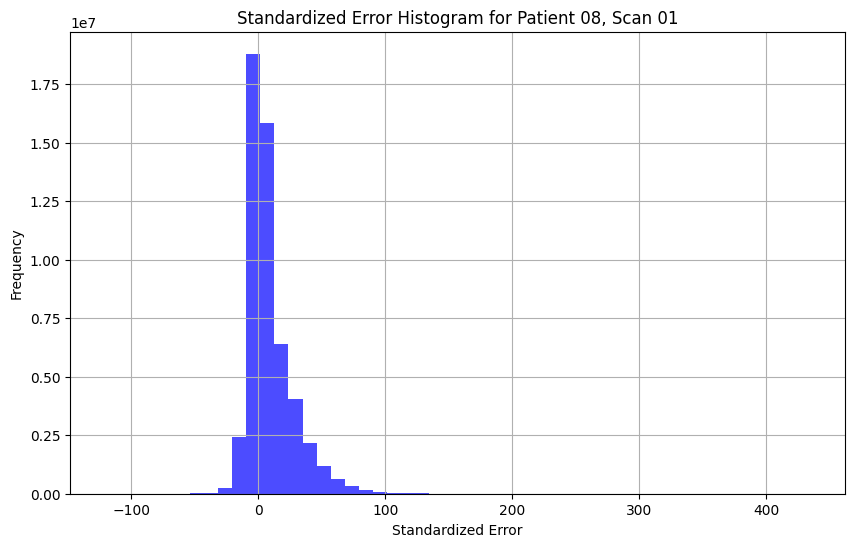

Patient 08, Scan 01:
  Percent with abs standardized error < 1: 9.39%
  Percent with abs standardized error < 2: 18.43%
  Percent with abs standardized error < 3: 26.83%
Processing reconstructions for patient 10, scan 01
Loaded 50 reconstructions for patient 10, scan 01


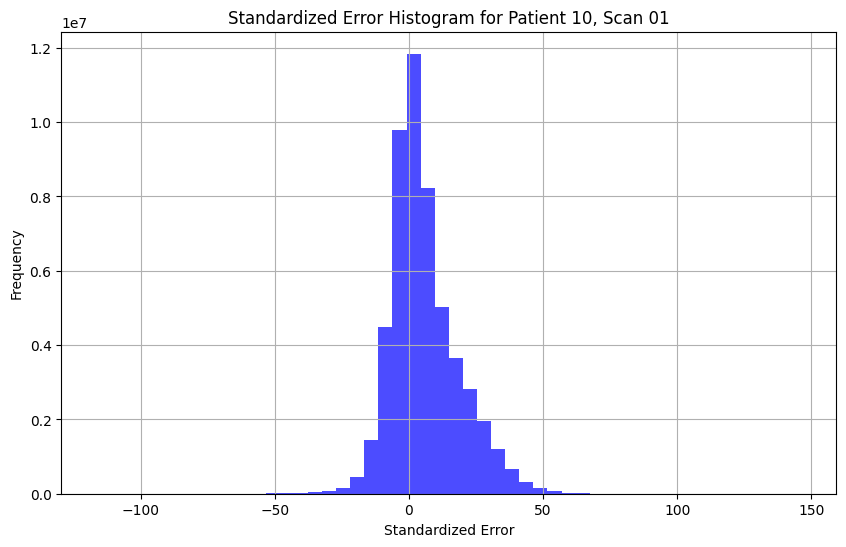

Patient 10, Scan 01:
  Percent with abs standardized error < 1: 8.90%
  Percent with abs standardized error < 2: 17.58%
  Percent with abs standardized error < 3: 25.82%
Processing reconstructions for patient 14, scan 01
Loaded 50 reconstructions for patient 14, scan 01


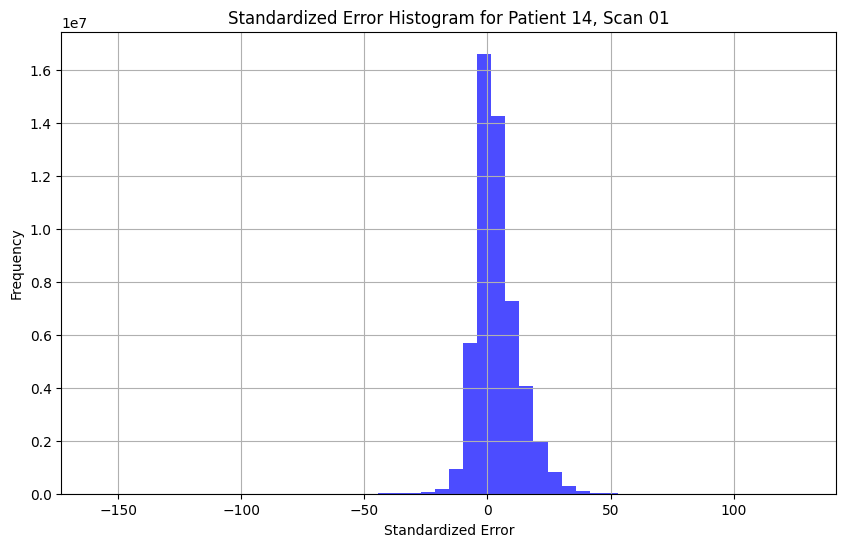

Patient 14, Scan 01:
  Percent with abs standardized error < 1: 12.53%
  Percent with abs standardized error < 2: 24.47%
  Percent with abs standardized error < 3: 35.36%
Processing reconstructions for patient 14, scan 02
Loaded 50 reconstructions for patient 14, scan 02


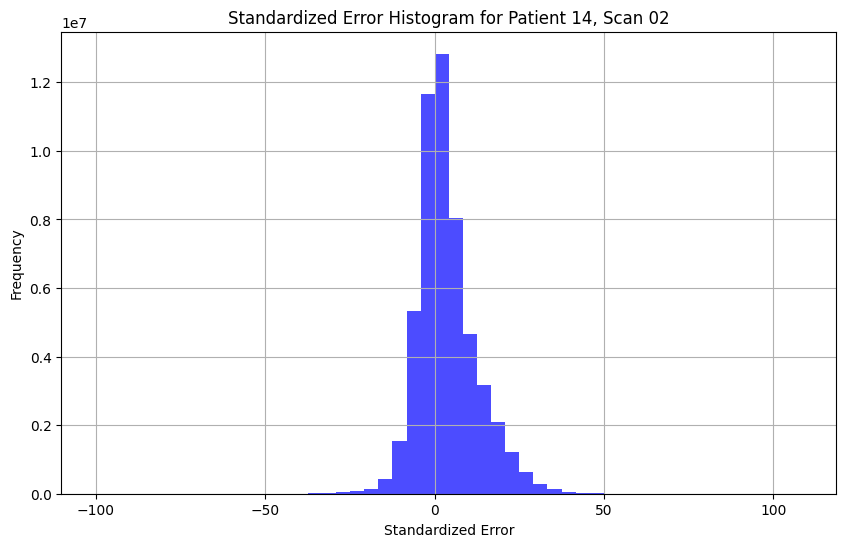

Patient 14, Scan 02:
  Percent with abs standardized error < 1: 12.56%
  Percent with abs standardized error < 2: 24.58%
  Percent with abs standardized error < 3: 35.58%
Processing reconstructions for patient 15, scan 01
Loaded 50 reconstructions for patient 15, scan 01


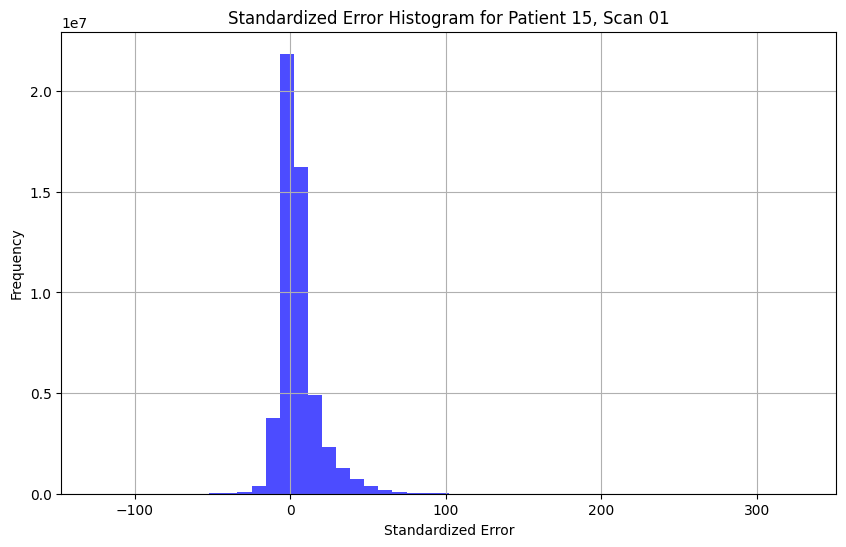

Patient 15, Scan 01:
  Percent with abs standardized error < 1: 11.67%
  Percent with abs standardized error < 2: 22.87%
  Percent with abs standardized error < 3: 33.22%
Processing reconstructions for patient 20, scan 01
Loaded 50 reconstructions for patient 20, scan 01


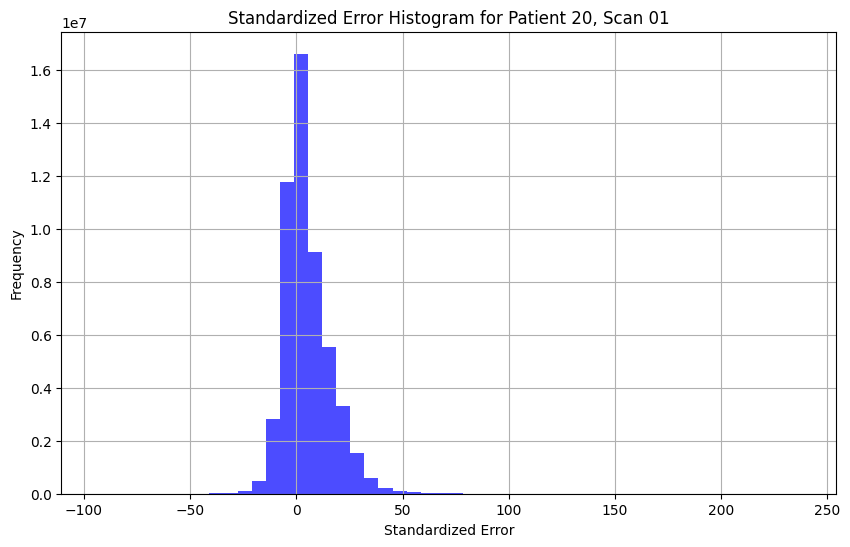

Patient 20, Scan 01:
  Percent with abs standardized error < 1: 10.42%
  Percent with abs standardized error < 2: 20.46%
  Percent with abs standardized error < 3: 29.84%


In [19]:
# Now go through each patient and scan, load the reconstructions
# calclate the mean and std (pixel-wise) and the error from GT
for (patient, scan), recon_paths in recon_paths_dict.items():
    print(f"Processing reconstructions for patient {patient}, scan {scan}")
    
    # Load ground truth
    gt_path = gt_paths_dict[(patient, scan)]
    gt_recon = torch.load(gt_path).cpu().numpy()
    
    # Initialize lists to hold reconstructions
    reconstructions = []
    
    for recon_path in recon_paths:
        recon = torch.load(recon_path).cpu().numpy()
        reconstructions.append(recon)

    print(f"Loaded {len(reconstructions)} reconstructions for patient {patient}, scan {scan}")
    
    # Convert to numpy array for easier manipulation
    reconstructions = np.array(reconstructions)
    
    # Calculate mean and std across the first axis (across models or passthroughs)
    mean_recon = np.mean(reconstructions, axis=0)
    std_recon = np.std(reconstructions, axis=0)
    
    # Calculate error from ground truth
    error = mean_recon - gt_recon
    
    # Calculate standardized error
    standardized_error = error / (std_recon + 1e-8)  # Adding a small value to avoid division by zero

    # Plot a histogram of the standardized error
    plt.figure(figsize=(10, 6))
    plt.hist(standardized_error.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Standardized Error Histogram for Patient {patient}, Scan {scan}')
    plt.xlabel('Standardized Error')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

    # Calculate and print percent with abs standardized error < 1, < 2, < 3
    percent_within_1 = np.mean(np.abs(standardized_error) < 1) * 100
    percent_within_2 = np.mean(np.abs(standardized_error) < 2) * 100
    percent_within_3 = np.mean(np.abs(standardized_error) < 3) * 100
    print(f"Patient {patient}, Scan {scan}:")
    print(f"  Percent with abs standardized error < 1: {percent_within_1:.2f}%")
    print(f"  Percent with abs standardized error < 2: {percent_within_2:.2f}%")
    print(f"  Percent with abs standardized error < 3: {percent_within_3:.2f}%")